In [62]:
from copyreg import pickle

from FQI_agent import collect_samples, rf_fqi
from env_hiv import HIVPatient
from utils import greedy_action_FQI

In [34]:
environment = HIVPatient()

## 1

In [35]:
S,A,R,S2,D = collect_samples(environment, int(1e4))
print("nb of collected samples:", S.shape[0])
for i in range(3):
    print("sample", i, "\n  state:", S[i], "\n  action:", A[i], "\n  reward:", R[i], "\n  next state:", S2[i], "\n terminal?", D[i])

100%|██████████| 10000/10000 [02:33<00:00, 64.97it/s]

nb of collected samples: 10000
sample 0 
  state: [1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01] 
  action: [0] 
  reward: 17608.1 
  next state: [1.63572059e+05 1.19450569e+04 4.99536372e+00 4.56109782e+01
 6.39192996e+04 2.39127429e+01] 
 terminal? False
sample 1 
  state: [1.63572059e+05 1.19450569e+04 4.99536372e+00 4.56109782e+01
 6.39192996e+04 2.39127429e+01] 
  action: [1] 
  reward: 15720.812904409093 
  next state: [1.84279276e+05 5.05037709e+03 1.54797477e+01 4.26986832e+01
 1.91847138e+04 2.43162780e+01] 
 terminal? False
sample 2 
  state: [1.84279276e+05 5.05037709e+03 1.54797477e+01 4.26986832e+01
 1.91847138e+04 2.43162780e+01] 
  action: [1] 
  reward: 20597.806650144703 
  next state: [2.12833057e+05 3.08876935e+03 2.56954566e+01 4.26148998e+01
 1.16980138e+04 2.57333870e+01] 
 terminal? False


In [36]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

SA = np.append(S,A,axis=1)
value = R.copy()

Q1 = RandomForestRegressor()
Q1.fit(SA,value);

In [37]:
print("training MSE:", np.mean((value-Q1.predict(SA))**2))

training MSE: 126221.56817943728


## 2

In [38]:
gamma = .9
nb_iter = 10
nb_actions = environment.action_space.n
Qfunctions = rf_fqi(S, A, R, S2, D, nb_iter, nb_actions, gamma)

100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


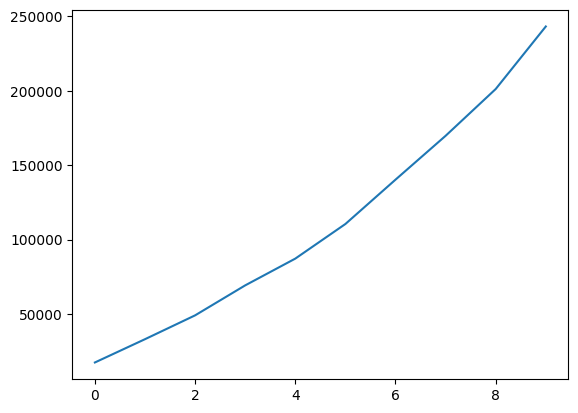

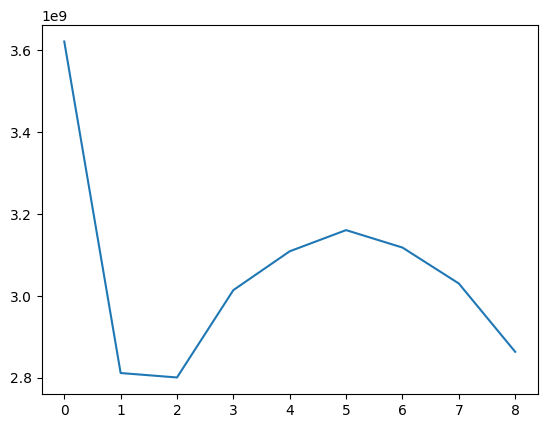

In [39]:
import matplotlib.pyplot as plt

# Value of an initial state across iterations
s0,_ = environment.reset()
Vs0 = np.zeros(nb_iter)
for i in range(nb_iter):
    Qs0a = []
    for a in range(environment.action_space.n):
        s0a = np.append(s0,a).reshape(1, -1)
        Qs0a.append(Qfunctions[i].predict(s0a))
    Vs0[i] = np.max(Qs0a)
plt.plot(Vs0)

# Bellman residual
residual = []
for i in range(1,nb_iter):
    residual.append(np.mean((Qfunctions[i].predict(SA)-Qfunctions[i-1].predict(SA))**2))
plt.figure()
plt.plot(residual);

In [41]:
Qfunctions[0]

RandomForestRegressor()

In [55]:
import pickle

print(Qfunctions)
with open('FQI_Q_functions.pkl', 'wb') as file:
    pickle.dump(Qfunctions, file)

[RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()]


In [57]:
with open('FQI_Q_functions.pkl', 'rb') as f:
    QfunctionsLoaded = pickle.load(f)
print(QfunctionsLoaded)

[RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()]


In [61]:
s,_ = environment.reset()
for t in range(500):
    a = greedy_action_FQI(QfunctionsLoaded[-1],s,environment.action_space.n)
    s2,r,d,trunc,_ = environment.step(a)
    s = s2
    if d:
        break